In [1]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import pandas as pd
from matplotlib import pyplot as plt
import sklearn
from sklearn.decomposition import PCA
import numpy as np

TRAINING_FRACTION = 0.8
N_DENSE = 4
L=16

In [2]:
user = 1
if user == 1:
    prefix_s3 = "/home/owen/"
    prefix_data = "/home/owen/repos/"
elif user == 2:
    prefix_data = "/Users/omyers/repos/"

In [3]:
df_bins = pd.read_csv("{prefix_data}z3support/data/SpinMLData/2DIsing/L-{L}/L-{L}-T-1-5/bins_L-{L}-T-1-5.txt".format(L=L,prefix_data=prefix_data), sep="\t")
df_conf = pd.read_csv("{prefix_data}z3support/data/SpinMLData/2DIsing/L-{L}/L-{L}-T-1-5/spinConfigs_L-{L}-T-1-5.txt".format(L=L,prefix_data=prefix_data), delimiter=r"\s+", header=None)

In [4]:
df_bins

,# L,T,binNum,E,ESq,AccRate_local,AccRate_clust,sigma,absSigma
0,16,1,1,-1.997375,3.98958935546875,0.0007338671875,1,-0.0959296875,0.9993359375
1,16,1,2,-1.997296875,3.98928051757813,0.0007177734375,1,-0.07590625,0.9993125
2,16,1,3,-1.996859375,3.98754760742188,0.0007245703125,1,-0.020015625,0.999203125
3,16,1,4,-1.997,3.9881083984375,0.00071078125,1,0.0379921875,0.9992265625
4,16,1,5,-1.997140625,3.98866528320313,0.00071921875,1,0.0338203125,0.9992578125
...,...,...,...,...,...,...,...,...,...
4999,16,5,996,-0.4278125,0.1926962890625,0.6918837109375,1,0.004671875,0.0836875
5000,16,5,997,-0.43128125,0.19522314453125,0.692264140625,1,0.003390625,0.085640625
5001,16,5,998,-0.4259375,0.19078955078125,0.691955390625,1,0.005828125,0.085140625
5002,16,5,999,-0.42375,0.18926171875,0.6920080078125,1,-0.006171875,0.08253125


In [5]:
df_bins.iloc[1000][1]

' T '

In [6]:
df_bins = df_bins[df_bins[' T '] != ' T ']

In [7]:
df_bins = df_bins.astype(
    {
        " T ": int,
        " binNum": int,
    }
)

In [8]:
df_conf

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-1,-1,-1,-1,-1,-1,1,1,-1,1,...,-1,1,1,1,-1,1,1,1,1,-1
4996,-1,1,-1,1,1,-1,-1,-1,1,1,...,-1,-1,1,-1,1,1,1,-1,1,1
4997,1,-1,-1,-1,1,1,-1,1,1,1,...,-1,1,1,1,-1,-1,-1,-1,1,-1
4998,1,-1,-1,1,-1,-1,-1,-1,-1,-1,...,1,-1,-1,1,1,-1,1,1,-1,1


## Get the temp and magnatization into the configuration dataframe

In [9]:
df_conf["T"] = df_bins[" T "]

In [10]:
df_conf.columns

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       247, 248, 249, 250, 251, 252, 253, 254, 255, 'T'],
      dtype='object', length=257)

In [11]:
mean_col = df_conf[0].copy()
for i in range(1, L):
    mean_col += df_conf[i]

mean_col /= L

In [12]:
df_conf["M"] = mean_col

In [13]:
#filterned_confs = df_conf[(df_conf["T"] < 1.5) | (df_conf["T"] > 4.5)]
filterned_confs = df_conf

In [14]:
train_with_meta_info = filterned_confs.sample(frac=TRAINING_FRACTION, axis=0)
test_with_meta_info = filterned_confs.drop(index=train_with_meta_info.index)
train = train_with_meta_info.drop(["T","M"], axis=1)
test = test_with_meta_info.drop(["T","M"], axis=1)

In [15]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
2376,1,-1,-1,-1,-1,-1,-1,1,1,1,...,-1,-1,1,-1,1,-1,-1,-1,-1,-1
187,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4254,1,-1,1,1,-1,-1,-1,-1,-1,1,...,-1,-1,-1,-1,-1,1,1,-1,-1,-1
1507,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3737,1,-1,-1,1,1,1,-1,1,1,1,...,1,1,-1,1,-1,1,1,-1,1,1


In [16]:
img_pca = PCA(n_components=N_DENSE)

In [17]:
img_pca.fit(train)

PCA(n_components=4)

In [18]:
components = img_pca.transform(filterned_confs.drop(["T","M"], axis=1))

In [19]:
components.shape

(5000, 4)

In [20]:
filterned_confs["T"]

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
4995    5.0
4996    5.0
4997    5.0
4998    5.0
4999    5.0
Name: T, Length: 5000, dtype: float64

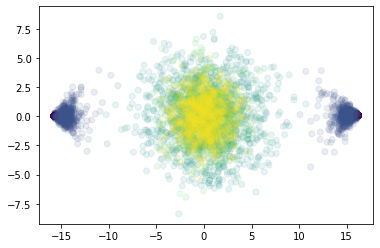

In [21]:
plt.scatter(components[:,0], components[:,1], c=pd.to_numeric(filterned_confs["T"]), alpha=0.1)

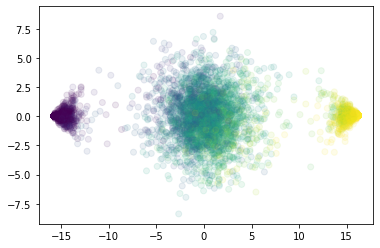

In [22]:
plt.scatter(components[:,0], components[:,1], c=pd.to_numeric(filterned_confs["M"]), alpha=0.1)

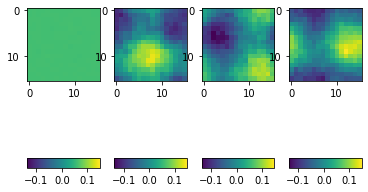

In [23]:
vmax = 0.0
vmin = 0.0
for i in range(N_DENSE):
    if max(img_pca.components_[i]) > vmax:
        vmax = max(img_pca.components_[i])
    
    if min(img_pca.components_[i]) < vmin:
        vmin = min(img_pca.components_[i])
        

fig_pca, (axes_pca, ax_color) = plt.subplots(2,N_DENSE, gridspec_kw={"height_ratios":[1, 0.05]})
im_list = []
for i, ax in enumerate(axes_pca.flat):
    im = ax.imshow(img_pca.components_[i].reshape(L,L), vmin=vmin, vmax=vmax)
    im_list.append(im)

for i, ax in enumerate(ax_color.flat):
    fig_pca.colorbar(im_list[i], cax=ax, orientation="horizontal")
plt.savefig("{}/s3-bucket/ising/pca_weights_as_image_l{}".format(prefix_s3, L))

In [24]:
df_components = pd.DataFrame(data={"c0": components[:,0], "c1": components[:,1], "T": pd.to_numeric(filterned_confs["T"])})

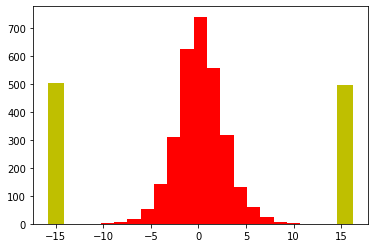

In [25]:
component_number = 0
plt.hist(df_components[df_components["T"] > 2]["c{}".format(component_number)], bins=15, color="r")
plt.hist(df_components[df_components["T"] < 2]["c{}".format(component_number)], bins=20, color="y")
#plt.show()
plt.savefig("{}/s3-bucket/reproduction/fig_2/pca_latent_param_hist_l{}.png".format(prefix_s3, L))

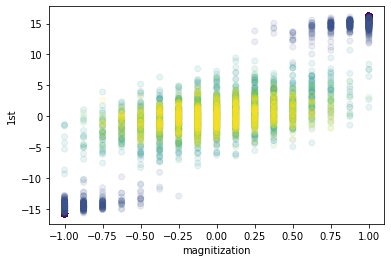

In [45]:
plt.scatter(pd.to_numeric(filterned_confs["M"]), components[:,0], c=pd.to_numeric(filterned_confs["T"]), alpha=0.1)
plt.xlabel("magnitization")
plt.ylabel("1st")
plt.savefig("{}/s3-bucket/reproduction/fig_2/pca_scatter_latent_vs_mag_color_by_t_l{}.png".format(prefix_s3, L))

# Simple Autoencoder

In [26]:
simp_ae = tf.keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(L*L,)),
        keras.layers.Dense(N_DENSE, use_bias=False, name='latent_space'),
        keras.layers.Dense(L*L),
    ]
)


2022-06-01 19:44:33.161599: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2022-06-01 19:44:33.161639: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: owen-PRIME-Z390-A
2022-06-01 19:44:33.161644: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: owen-PRIME-Z390-A
2022-06-01 19:44:33.161800: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.129.6
2022-06-01 19:44:33.161823: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.103.1
2022-06-01 19:44:33.161828: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 470.103.1 does not match DSO version 470.129.6 -- cannot find working devices in this configuration
2022-06-01 19:44:33.162508: I tensorflow/core/platform/cpu_feature_guard.c

In [27]:
simp_ae.output_shape

(None, 256)

In [28]:
simp_ae.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 latent_space (Dense)        (None, 4)                 1024      
                                                                 
 dense (Dense)               (None, 256)               1280      
                                                                 
Total params: 2,304
Trainable params: 2,304
Non-trainable params: 0
_________________________________________________________________


In [29]:
tb_callback = keras.callbacks.TensorBoard(
    log_dir='tb_log_dir_notebook',
    histogram_freq=2,  
    write_graph=True,
    write_images=True
)

In [30]:
simp_ae.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [31]:
simp_ae.fit(
    batch_size=16,
    x=filterned_confs.drop(["T","M"], axis=1),
    y=filterned_confs.drop(["T","M"], axis=1),
    epochs=100,
    callbacks=[tb_callback]
)

Epoch 1/100
313/313 [==============================] - 1s 1ms/step - loss: 0.6875 - mae: 0.6821
Epoch 2/100
313/313 [==============================] - 0s 667us/step - loss: 0.6079 - mae: 0.6137
Epoch 3/100
313/313 [==============================] - 0s 688us/step - loss: 0.5965 - mae: 0.6035
Epoch 4/100
313/313 [==============================] - 0s 637us/step - loss: 0.5907 - mae: 0.5974
Epoch 5/100
313/313 [==============================] - 0s 690us/step - loss: 0.5882 - mae: 0.5951
Epoch 6/100
313/313 [==============================] - 0s 631us/step - loss: 0.5871 - mae: 0.5938
Epoch 7/100
313/313 [==============================] - 0s 681us/step - loss: 0.5866 - mae: 0.5933
Epoch 8/100
313/313 [==============================] - 0s 671us/step - loss: 0.5864 - mae: 0.5930
Epoch 9/100
313/313 [==============================] - 0s 755us/step - loss: 0.5862 - mae: 0.5929
Epoch 10/100
313/313 [==============================] - 0s 674us/step - loss: 0.5861 - mae: 0.5927
Epoch 11/100
313/313 

In [32]:
mid_layer = simp_ae.get_layer('latent_space')

In [33]:
mid_layer.get_weights()[0].shape

(256, 4)

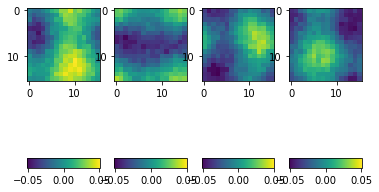

In [54]:
vmax = 0.0
vmin = 0.0
for i in range(N_DENSE):
    cur_w = mid_layer.get_weights()[0][:,-(i+1)]
    if max(cur_w) > vmax:
        vmax = max(cur_w)
    
    if min(cur_w) < vmin:
        vmin = min(cur_w)
        

fig, (axes, ax_color) = plt.subplots(2,N_DENSE, gridspec_kw={"height_ratios":[1, 0.05]})
im_list = []
for i, ax in enumerate(axes.flat):
    im = ax.imshow(mid_layer.get_weights()[0][:,-(i+1)].reshape(L,L), vmin=vmin, vmax=vmax)
    im_list.append(im)

for i, ax in enumerate(ax_color.flat):
    fig.colorbar(im_list[i], cax=ax, orientation="horizontal")

plt.savefig("{}/s3-bucket/ising/ae_weights_as_image_l{}".format(prefix_s3, L))
#fig, axes = plt.subplots(1,N_DENSE)
#for i, ax in enumerate(axes.flat):
#    ax.imshow(mid_layer.get_weights()[0][:,-(i+1)].reshape(L,L))

In [50]:
max(mid_layer.get_weights()[0][:,-(i+1)])

0.034677822

In [35]:
full_latent_out = simp_ae.predict(filterned_confs.drop(["T","M"], axis=1))

157/157 [==============================] - 0s 505us/step


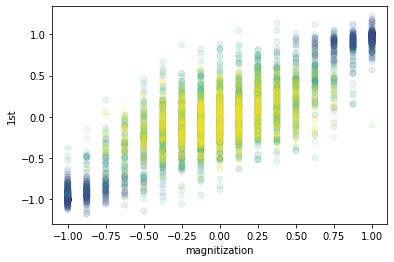

In [46]:
plt.scatter(pd.to_numeric(filterned_confs["M"]), full_latent_out[:,0], c=pd.to_numeric(filterned_confs["T"]), alpha=0.1)
plt.xlabel("magnitization")
plt.ylabel("1st")
plt.savefig("{}/s3-bucket/reproduction/fig_2/ae_scatter_latent_vs_mag_color_by_t_l{}.png".format(prefix_s3, L))

# Simple Autoencoder with Reshape

In [37]:
simp_ae = tf.keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(L, L, 1)),
        keras.layers.Flatten(),
        keras.layers.Dense(N_DENSE, use_bias=False, name='latent_space'),
        keras.layers.Dense(units=L*L),
        keras.layers.Reshape(target_shape=(L, L, 1))
    ]
)

# Fig 2.c

In [38]:
filterned_confs["latent_1"] = full_latent_out[:,0]

In [39]:
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)

In [40]:
filterned_confs.to_sql('filtered_confs', con=engine, if_exists='append')

In [41]:
avg_m_out = engine.execute(
"""
    select 
        t,
        avg(abs(m)),
        avg(abs(latent_1))
    from filtered_confs
    group by t
""").fetchall()

In [42]:
avg_m_out[1:]

[(1.0, 0.99975, 1.0002338646054267),
 (2.0, 0.9085, 0.9173381292819976),
 (3.0, 0.339625, 0.35191529381333386),
 (4.0, 0.258625, 0.24692795158014633),
 (5.0, 0.23795180722891565, 0.1971394226854306)]

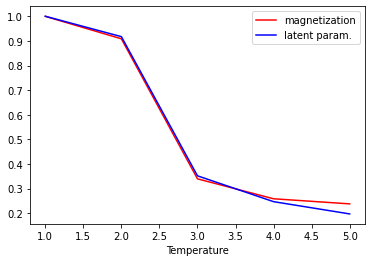

In [43]:
plt.plot(
    [i[0] for i in avg_m_out[1:]],
    [i[1] for i in avg_m_out[1:]],
    c='r',
    label="magnetization"
)
plt.plot(
    [i[0] for i in avg_m_out[1:]],
    [i[2] for i in avg_m_out[1:]],
    c='b',
    label="latent param."
)
plt.xlabel("Temperature")
plt.legend()
plt.savefig("{}/s3-bucket/reproduction/fig_2/pca_magnitization_and_latent_param_vs_temp_l{}.png".format(prefix_s3, L))

# Look into this

In [44]:
#engine.execute(
#"""
#    select 
#    m
#    from filterned_confs
#    where t is null
#""").fetchall()